# Aprendizaje no supervisado: clustering

## Descripción del Dataset: Rendimiento de Freestylers

Este dataset contiene información sobre las puntuaciones promedio de diversos freestylers en diferentes categorías relacionadas con su desempeño en competencias. Cada fila representa a un freestyler, y las columnas corresponden a las métricas evaluadas.

## Columnas del Dataset
- **FREESTYLER**: Nombre del freestyler.
- **MEDIA**: Puntuación promedio general.
- **FLOW**: Calidad y habilidad en el manejo de ritmos.
- **ESTRUCTURA**: Capacidad de construir patrones rítmicos y líricos coherentes.
- **INGENIO**: Nivel de creatividad y originalidad en las respuestas y rimas.
- **RESPUESTA**: Habilidad para responder en tiempo real a los oponentes.
- **PUNCHLINE**: Calidad de las rimas más impactantes o memorables.
- **AGRESIVIDAD**: Nivel de intensidad y fuerza en la entrega.

## Resumen del Dataset
- **Cantidad de freestylers**: 28
- **Rango de puntuaciones**: Entre 83 y 94.
- **Puntuación máxima (MEDIA)**: 94, alcanzada por **Chuty** y **Aczino**.
- **Categoría con mayor variabilidad**: Según las puntuaciones observadas, la categoría **FLOW** tiene diferencias notables entre freestylers.

## Ejemplo de Datos
| FREESTYLER | MEDIA | FLOW | ESTRUCTURA | INGENIO | RESPUESTA | PUNCHLINE | AGRESIVIDAD |
|------------|-------|------|------------|---------|-----------|-----------|-------------|
| Chuty      | 94    | 92   | 90         | 94      | 93        | 94        | 93          |
| Aczino     | 94    | 89   | 88         | 94      | 94        | 94        | 93          |
| Gazir      | 93    | 87   | 88         | 93      | 93        | 93        | 91          |



## Objetivo 1: Crear un tierlist de freestylers


La comunidad de freestyle es conocida por crear tierlist de manera contínua al aproximarse fechas importantes en su ámbito. Con motivo de la celebración de la Final Internacional de RBB, se decide crear un método para realizarlo de forma imparcial y automatizada. Para ello ten en cuenta el dataset *top28*

Antes de comenzar, describe brevemente como lo harías.

### Inicializamos spark

In [34]:
import findspark

findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("""select 'spark' as hola """)
df.show()

print("Empezamos en 3, 2, 1 ...");

+-----+
| hola|
+-----+
|spark|
+-----+

Empezamos en 3, 2, 1 ...


### Algoritmos clustering

In [ ]:
# Importar las librerías necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt

# Crear la sesión de Spark
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()

# Cargar el archivo Excel en un DataFrame de Spark
file_path = "final_RBB.csv"
df = (
    spark.read.format("csv")
    .option("header", "true")
    .option("inferSchema", "true")
    .load(file_path)
)

# Mostrar los datos cargados
df.show(5)


+----------+-----+----+----------+-------+---------+---------+-----------+
|FREESTYLER|MEDIA|FLOW|ESTRUCTURA|INGENIO|RESPUESTA|PUNCHLINE|AGRESIVIDAD|
+----------+-----+----+----------+-------+---------+---------+-----------+
|     Gazir|   96|  90|        89|     96|       96|       95|         92|
|  Valles T|   95|  97|        93|     94|       95|       95|         95|
|  El Menor|   95|  92|        95|     96|       95|       95|         94|
|    Stuart|   94|  89|        90|     95|       94|       94|         92|
|    Rapder|   93|  85|        84|     92|       93|       93|         93|
+----------+-----+----+----------+-------+---------+---------+-----------+
only showing top 5 rows



### Vamos a facilitar el proceso, construyendo un pipeline

In [ ]:
from pyspark.ml import Pipeline

# Paso 1: VectorAssembler para combinar las columnas numéricas en una sola columna de características
assembler = VectorAssembler(
    inputCols=[
        "MEDIA",
        "FLOW",
        "ESTRUCTURA",
        "INGENIO",
        "RESPUESTA",
        "PUNCHLINE",
        "AGRESIVIDAD",
    ],
    outputCol="features",
)

# Paso 2: Escalado de características para normalizar los datos
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Paso 3: Aplicación de K-means para clustering
kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="prediction")

# Crear el pipeline
pipeline = Pipeline(stages=[assembler, scaler, kmeans])

A partir de ahora ya no es necesario que des todos los pasos necesarios para realizar el procesado de datos. Únicamente tienes que invocar el pipeline

### Con qué valor de k nos quedamos?
Qué estudios podemos realizar para comprobar el valor de k más adecuado?

Pista: Uno de los métodos los vimos en clase, el otro es analizando el factor *silhouette*

In [37]:
from pyspark.ml.evaluation import ClusteringEvaluator


def doKmeans(k):
    # Permite reutilizarlo cambiando valores intermedios
    kmeans.setK(k)
    # Reentrenar el pipeline en el mismo dataset con el nuevo valor de k
    model = pipeline.fit(df)
    # Hacer predicciones con el nuevo modelo
    newPreds = model.transform(df)
    return newPreds


def checkSillouette(k):
    # Llamamos a la función
    newPreds = doKmeans(k)
    # Evaluar la calidad del clustering con el nuevo valor de k
    evaluator = ClusteringEvaluator(
        predictionCol="prediction",
        featuresCol="scaledFeatures",
        metricName="silhouette",
    )
    silhouette_score_kX = evaluator.evaluate(newPreds)
    print(f"Índice de silhouette para k={k}: {silhouette_score_kX}")


for i in range(2, 10):
    checkSillouette(i)

Índice de silhouette para k=2: 0.67311929025729
Índice de silhouette para k=3: 0.5405630829015937
Índice de silhouette para k=4: 0.38581907512262636
Índice de silhouette para k=5: 0.4099581974175166


Exception ignored in: <function JavaWrapper.__del__ at 0x7fa37d39e8e0>
Traceback (most recent call last):
  File "/home/josugoar/miniconda3/envs/tdm/lib/python3.12/site-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
                                              ^^^^^^^^^^^^^^
AttributeError: 'MinMaxScaler' object has no attribute '_java_obj'


Índice de silhouette para k=6: 0.4742508540373502
Índice de silhouette para k=7: 0.3950367100748131
Índice de silhouette para k=8: 0.3951077459255319
Índice de silhouette para k=9: 0.39443170843462194


#### La gráfica del codo (o "elbow plot").
Es una técnica visual que se utiliza en clustering para ayudar a determinar el número óptimo de clusters (o grupos) en los datos, específicamente cuando se usa el algoritmo K-means.

### Ahora queremos representar los clusters en 2 dimensiones


In [38]:
predictions = doKmeans(4)

# Reducir la dimensionalidad con PCA para visualización en 2D
pca = PCA(k=2, inputCol="scaledFeatures", outputCol="pcaFeatures")
pca_model = pca.fit(predictions)
df_pca = pca_model.transform(predictions)

# Seleccionar columnas
pca_data = df_pca.select("pcaFeatures", "prediction", "FREESTYLER").collect()

# Extraer los valores de PCA y las predicciones
pca_x = [row["pcaFeatures"][0] for row in pca_data]
pca_y = [row["pcaFeatures"][1] for row in pca_data]
predictions = [row["prediction"] for row in pca_data]

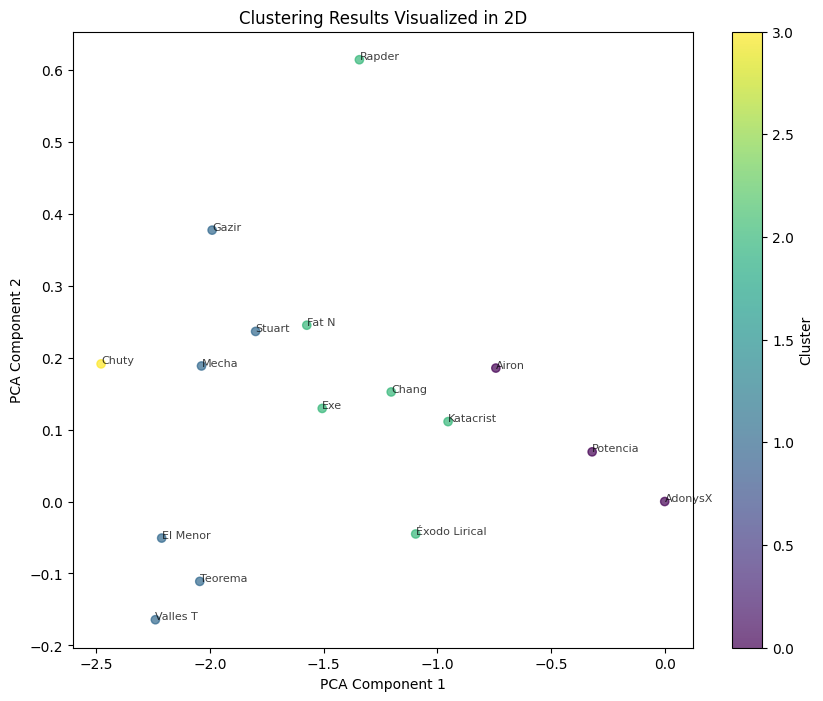

In [39]:
labels = [row["FREESTYLER"] for row in pca_data]  # Identidad de cada carta o fila
# Visualizar los resultados del clustering en 2D
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_x, pca_y, c=predictions, cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Clustering Results Visualized in 2D")

# Añadir etiquetas a cada punto
for i, label in enumerate(labels):
    plt.annotate(label, (pca_x[i], pca_y[i]), fontsize=8, alpha=0.75)

plt.show()


/tmp/ipykernel_1851640/396539990.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", np.unique(clusters).size)


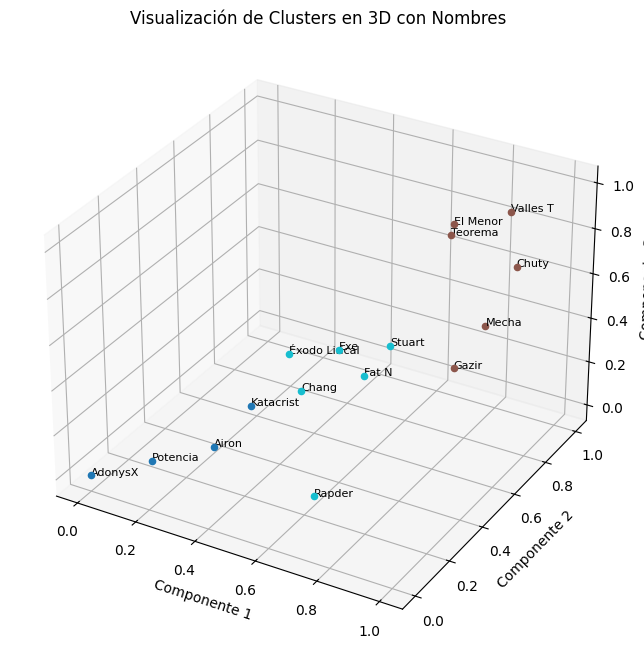

In [40]:
import numpy as np

df_clusters = doKmeans(3)

# Convertir los datos y los clusters a un array de NumPy para visualización
data = np.array(
    df_clusters.select("scaledFeatures")
    .rdd.map(lambda row: row.scaledFeatures.toArray())
    .collect()
)
clusters = np.array(df_clusters.select("prediction").rdd.flatMap(lambda x: x).collect())

# Asegurarse de que la columna "FREESTYLER" existe y extraer nombres si es así
if "FREESTYLER" in df_clusters.columns:
    names = df_clusters.select("FREESTYLER").rdd.flatMap(lambda x: x).collect()
else:
    names = [
        f"Punto {i}" for i in range(len(data))
    ]  # Etiquetas genéricas si no hay nombres disponibles

# Crear un gráfico 3D de dispersión
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Asignar colores a los clusters
colors = plt.cm.get_cmap("tab10", np.unique(clusters).size)

# Dibujar cada punto y añadir nombres sin duplicarlos
for i, (point, cluster) in enumerate(zip(data, clusters)):
    ax.scatter(
        point[0],
        point[1],
        point[2],
        label=f"Cluster {cluster}" if i == 0 else "",
        color=colors(cluster / np.unique(clusters).size),
    )
    ax.text(
        point[0], point[1], point[2], names[i], fontsize=8
    )  # Etiquetar el punto una vez

# Configuración del gráfico
ax.set_title("Visualización de Clusters en 3D con Nombres")
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
ax.set_zlabel("Componente 3")
plt.show()


## Objetivo 2: Búsqueda de sustitutos

Con el objetivo de buscar posibles sustitutos para la Final Internacional de RBB, se nos solicita crear un método que analice los participantes de dicha competición. Los participantes los puedes encontrar en *final_RBB*. Los sustitutos los debes escoger del dataset anterior top28.csv

¿Qué participantes elegirías para sustituir a los siguientes freestylers?
* A) Chuty
* B) El Menor
* C) Potencia
* D) Stuart

Comenta brevemente los pasos a realizar para cumplir el objetivo